In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文黑体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
%matplotlib inline

In [26]:
df = pd.read_excel("dataset/58606.23.06.2020.23.06.2025.1.0.0.cn.utf8.00000000.xls")

In [27]:
# 假设时间列名为 'datetime'，气温为 'T'
df['datetime'] = pd.to_datetime(df['当地时间 莲塘镇'])
df['hour'] = df['datetime'].dt.hour

# 先计算每一天的最高温和最低温
df['date'] = df['datetime'].dt.date
for day, group in df.groupby('date'):
    Tmax = group['T'].max()
    Tmin = group['T'].min()
    # 跳过当天全部缺失的情况
    if pd.isna(Tmax) or pd.isna(Tmin):
        continue
    for idx, row in group.iterrows():
        if pd.isna(row['T']):
            hour = row['hour']
            # 假设最低温在5点，最高温在14点
            # 归一化到[0, pi]区间
            x = (hour - 5) / (14 - 5)
            x = min(max(x, 0), 1)
            T_est = Tmin + (Tmax - Tmin) * np.sin(np.pi * x)
            # 限制范围
            T_est = min(max(T_est, Tmin), Tmax)
            df.at[idx, 'T'] = T_est

# 删除辅助列
df.drop(columns=['hour', 'date'], inplace=True)

C:\Users\Matwings\AppData\Local\Temp\ipykernel_20196\3872173488.py:2: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df['当地时间 莲塘镇'])


In [28]:
df.drop(columns=['ff10','ff3','N',"Cl","Nh",'Tg','sss',"E'","E",'Cm','Ch',"W1","W2","H","当地时间 莲塘镇"],axis=1, inplace=True)

In [29]:
dd_map = {
    "从北方吹来的风": 0,
    "从东北偏北方向吹来的风": 1,
    "从东北方吹来的风": 2,
    "从东北偏东方向吹来的风": 3,
    "从东方吹来的风": 4,
    "从东南偏东方向吹来的风": 5,
    "从东南方吹来的风": 6,
    "从东南偏南方向吹来的风": 7,
    "从南方吹来的风": 8,
    "从西南偏南方向吹来的风": 9,
    "从西南方吹来的风": 10,
    "从西南偏西方向吹来的风": 11,
    "从西方吹来的风": 12,
    "从西北偏西方向吹来的风": 13,
    "从西北方吹来的风": 14,
    "从西北偏北方向吹来的风": 15,
    "无风": 16
}
df["DD"] = df["DD"].map(dd_map).fillna(df["DD"])


In [30]:
# 先替换“无降水”为0
df["RRR"] = df["RRR"].replace("无降水", 0)
# 强制转换为数值类型，无法转换的变为NaN
df["RRR"] = pd.to_numeric(df["RRR"], errors="coerce")

for row in df.index:
    if pd.isna(df.loc[row, "RRR"]):
        # 向下查找下一个非缺失值
        next_row = row + 1
        while next_row in df.index and pd.isna(df.loc[next_row, "RRR"]):
            next_row += 1
        prev_row = row - 1
        while prev_row in df.index and pd.isna(df.loc[prev_row, "RRR"]):
            prev_row -= 1
        # 如果找到的前后都不是缺失值
        if next_row in df.index and prev_row in df.index:
            if df.loc[next_row, "RRR"] != 0 or df.loc[prev_row, "RRR"] != 0:
                df.loc[row, "RRR"] = np.average([df.loc[next_row, "RRR"], df.loc[prev_row, "RRR"]])
            elif df.loc[next_row, "RRR"] == 0 and df.loc[prev_row, "RRR"] == 0:
                df.loc[row, "RRR"] = 0
        # 只找到后面有数据
        elif next_row in df.index:
            df.loc[row, "RRR"] = df.loc[next_row, "RRR"]
        # 只找到前面有数据
        elif prev_row in df.index:
            df.loc[row, "RRR"] = df.loc[prev_row, "RRR"]
        # 前后都没有数据，直接填0
        else:
            df.loc[row, "RRR"] = 0

In [31]:
for i in range(len(df) - 1):
    # 填补P
    if pd.isna(df.loc[i, 'P']) and not pd.isna(df.loc[i, 'Pa']) and not pd.isna(df.loc[i + 1, 'P']):
        df.loc[i, 'P'] = df.loc[i + 1, 'P'] + df.loc[i, 'Pa']
    # 填补Pa
    if pd.isna(df.loc[i, 'Pa']) and not pd.isna(df.loc[i, 'P']) and not pd.isna(df.loc[i + 1, 'P']):
        df.loc[i, 'Pa'] = df.loc[i, 'P'] - df.loc[i + 1, 'P']

# 对剩余缺失值做线性插值
df['P'] = df['P'].interpolate(method='linear', limit_direction='both')
df['Pa'] = df['Pa'].interpolate(method='linear', limit_direction='both')

In [32]:
# 对U列缺失值做线性插值，保持趋势
df['U'] = df['U'].interpolate(method='linear', limit_direction='both')

In [33]:
for idx in df.index:
    # 填补Tn
    if pd.isna(df.loc[idx, 'Tn']):
        next_rows = df.loc[idx:idx+5, 'T']  # 包含当前行及后5行
        if next_rows.notna().any():
            df.loc[idx, 'Tn'] = next_rows.min()
    # 填补Tx
    if pd.isna(df.loc[idx, 'Tx']):
        next_rows = df.loc[idx:idx+5, 'T']
        if next_rows.notna().any():
            df.loc[idx, 'Tx'] = next_rows.max()

C:\Users\Matwings\AppData\Local\Temp\ipykernel_20196\1889171299.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_plot['VV'] = df_plot['VV'].replace('低于 0.1', 0.05)
d:\Softwares\miniconda\envs\ai-base\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Softwares\miniconda\envs\ai-base\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Softwares\miniconda\envs\ai-base\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from f

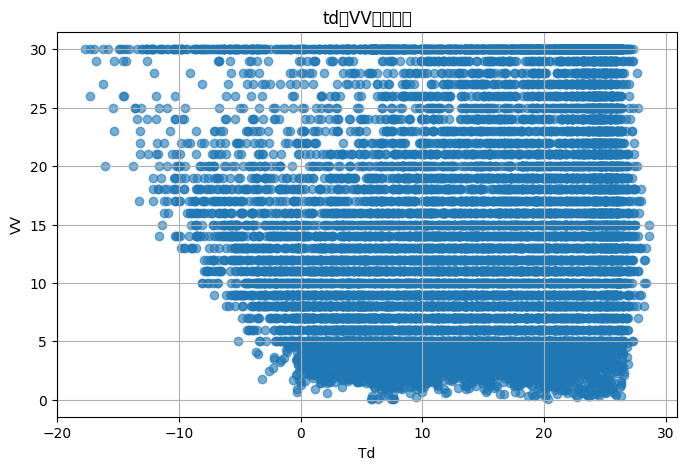

In [35]:
# 只保留td和VV都非缺失的数据
df_plot = df[['Td', 'VV']].dropna()
df_plot['VV'] = df_plot['VV'].replace('低于 0.1', 0.05)

plt.figure(figsize=(8, 5))
plt.scatter(df_plot['Td'], df_plot['VV'], alpha=0.6)
plt.xlabel('Td')
plt.ylabel('VV')
plt.title('td与VV的关系图')
plt.grid(True)
plt.show()